<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: 2.1 Modelling - Stroke Detector Model
> Authors: Michael King Sutanto, Eugene Matthew Cheong, Pius Yee

##### In this notebook 2.1, we will select and tune models for stroke detector.

---
## Table of Contents ##

### Notebook 2.1 Modelling - Stroke Detector Model ###

#### 1. Importing clean healthcare dataset

#### 2. Model Selection

[2.1 Train Test Split](#2.1-train-test-split)

[2.2 Sample to balance the data with Adaptive Synthetic Sampling (ADASYN)](#2.2-sample-to-balance-the-data-with-adaptive-synthetic-sampling-(ADASYN))

[2.2.1 Logistic Regression base model](#2.2.1-logistic-regression-base-model)

[2.2.2 KNN Classifier base model](#2.2.2-knn-classifier-base-model)

[2.2.3 CART base model](#2.2.3-cart-base-model)

[2.2.4 BaggingClassifier base model](#2.2.4-baggingclassifier-base-model)

[2.2.5 Random Forest Classifier base model](#2.2.5-random-forest-classifier-base-model)

[2.2.6 AdaBoost base model](#2.2.6-adaboost-base-model)

[2.2.7 SVC base model](#2.2.7-svc-base-model)

[2.2.8 XGBoost base model](#2.2.8-xgboost-base-model)

[2.3 Model Evaluation](#2.3-model-evaluation)

[2.4 Hyperparameter Tuning](#2.4-hyperparameter-tuning)

[2.4.1 Logistic Regression](#2.4.1-logistic-regression)

[2.4.2 XGBoost](#2.4.2-xgboost)

#### 3. Final Model

[3.0 Final Model](#3.0-final-model)

[3.1 ROC AUC](#3.1-roc-auc)

#### 4. Export model PKL

[4.0 Export model PKL](#4.0-export-model-pkl)

#### 5.0 Summary - Stroke Detector Model

[5.0 Summary - Stroke Detector Model](#5.0-Summary---Stroke-Detector-Model)

---

In [134]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn import FunctionSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline

# 1.0 Importing clean healthcare dataset

In [135]:
df = pd.read_csv('../datasets/healthcare-dataset-stroke-data.clean.csv')

# 2.0 Model Selection

In [136]:
df["stroke"].value_counts(normalize=True)

stroke
0    0.957416
1    0.042584
Name: proportion, dtype: float64

In [137]:
X = df.drop(['stroke','ever_married','Residence_type'], axis=1) # exclude irrelevant features
y = df["stroke"]

In [138]:
X.shape

(4908, 10)

## 2.1 Train Test Split

In [139]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [140]:
X_train['obesity_status'].value_counts()

obesity_status
2    1110
1    1009
3     800
4     411
5     328
0     268
Name: count, dtype: int64

## 2.2 Sample to balance the data with Adaptive Synthetic Sampling (ADASYN)

ADASYN is based on the idea of adaptively generating minority data samples according to their distributions: more synthetic data is generated for minority class samples that are harder to learn compared to those minority samples that are easier to learn.

The key idea of ADASYN algorithm is to use a density distribution as a criterion to automatically decide the number of synthetic samples that need to be generated for each minority data example.

In [141]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,employment_type,diabetic_status,obesity_status
0,0,67.0,0,1,1,1,228.69,36.6,1,1,1,2,4
1,0,80.0,0,1,1,0,105.92,32.5,0,1,1,1,3
2,1,49.0,0,0,1,1,171.23,34.4,2,1,1,2,3
3,1,79.0,1,0,1,0,174.12,24.0,0,1,1,2,1
4,0,81.0,0,0,1,1,186.21,29.0,1,1,1,2,2


### Before using oversampling with ADASYN

Text(0.5, 1.0, 'BMI vs. Age')

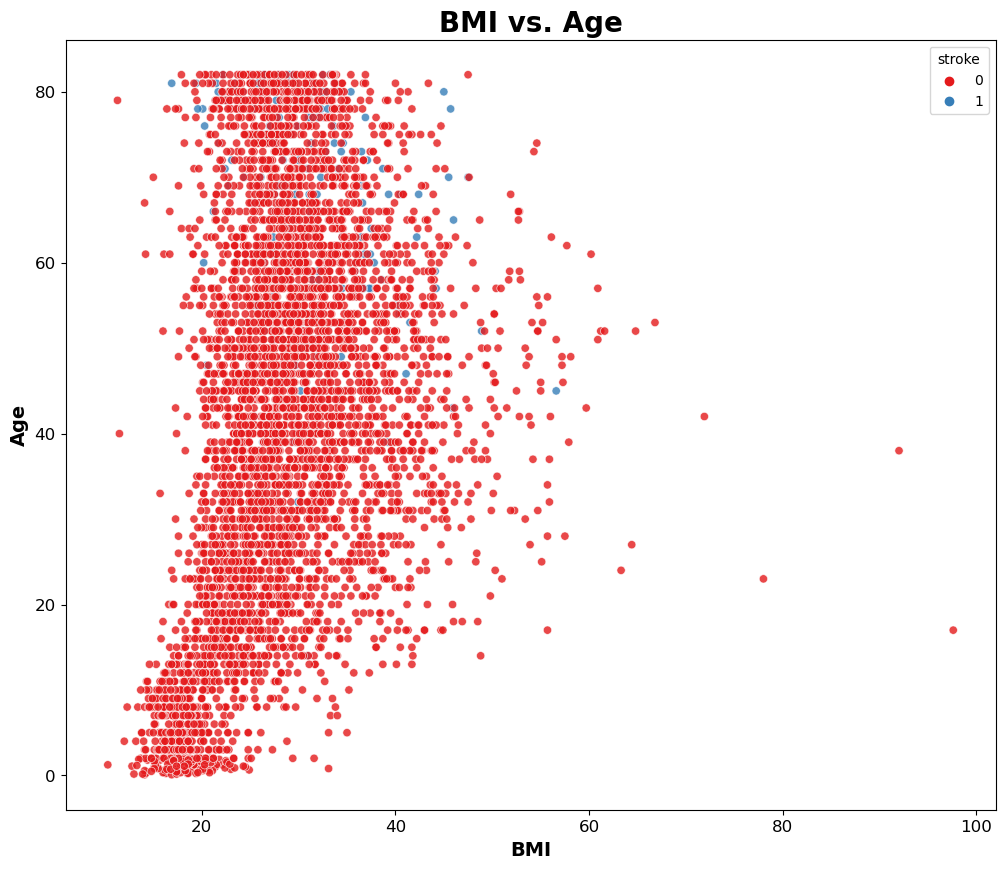

In [142]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=df, x="bmi", y="age", hue="stroke", palette="Set1", alpha = 0.8)

plt.xlabel('BMI', fontsize=14, weight='bold')
plt.ylabel('Age', fontsize=14, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("BMI vs. Age", fontsize=20, weight="bold")

### After oversampling with ADASYN

ADASYN generates more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

In [143]:
oversample = ADASYN(random_state=42)

In [144]:
# Our data is biased, we can fix this with SMOTE
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train)

In [145]:
y_train_resh.value_counts()

stroke
0    3759
1    3713
Name: count, dtype: int64

In [146]:
combined_oversample_df = pd.concat([X_train_resh, y_train_resh], axis=1)

Text(0.5, 1.0, 'BMI vs. Age')

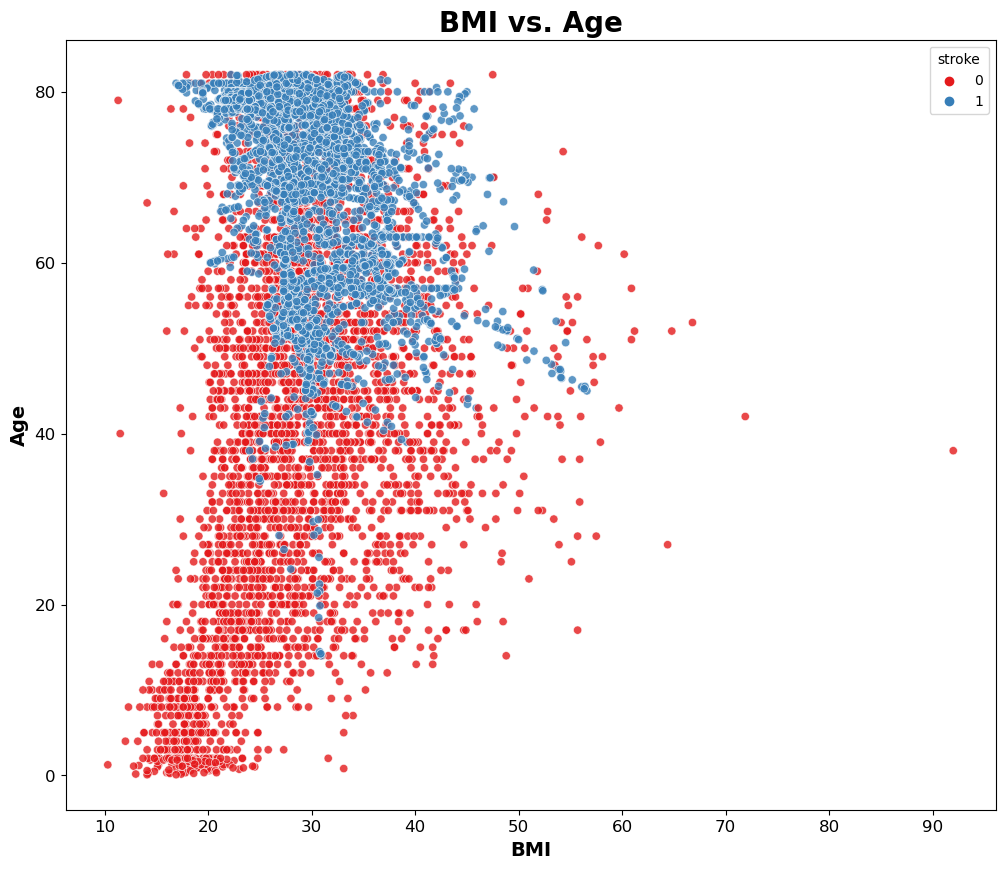

In [147]:
plt.figure(figsize=(12,10))
sns.scatterplot(data=combined_oversample_df, x="bmi", y="age", hue="stroke", palette="Set1", alpha = 0.8)

plt.xlabel('BMI', fontsize=14, weight='bold')
plt.ylabel('Age', fontsize=14, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title("BMI vs. Age", fontsize=20, weight="bold")

ADASYN adds more synthetic sampling to the minority.

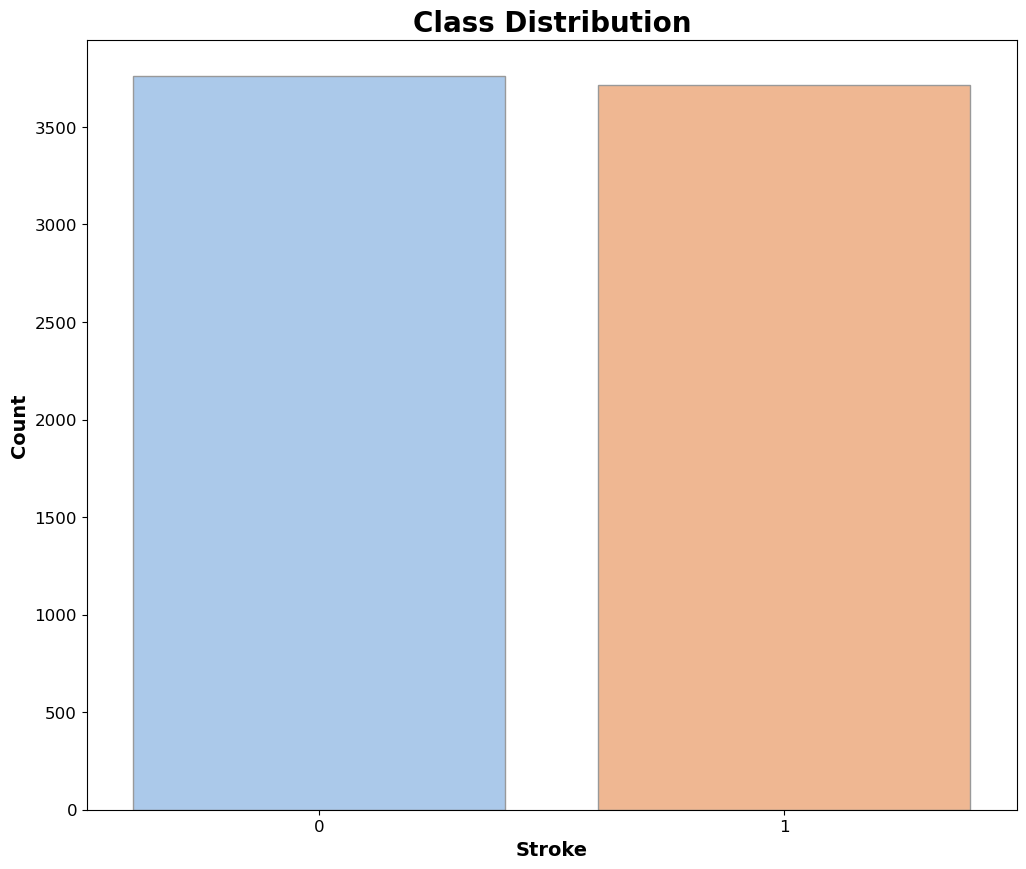

In [148]:
# plotting countplot for stroke
plt.figure(figsize=(12,10))
sns.countplot(x='stroke', data=combined_oversample_df, palette="pastel", edgecolor=".6")
plt.title('Class Distribution', fontsize=20, weight="bold")

plt.xlabel('Stroke', fontsize=14, weight='bold')
plt.ylabel('Count', fontsize=14, weight='bold')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

After oversampling, it looks more balanced now.

In [149]:
combined_oversample_df

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,employment_type,diabetic_status,obesity_status,stroke
0,0,43.000000,0,0,146.010000,31.500000,2,1,2,3,0
1,1,50.000000,0,0,103.810000,28.300000,0,1,1,2,0
2,0,9.000000,0,0,76.880000,18.000000,0,0,0,0,0
3,1,51.000000,0,0,82.590000,26.200000,1,1,0,2,0
4,0,32.000000,0,0,91.930000,30.200000,0,1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...
7467,0,75.811661,0,0,263.856732,31.490583,2,1,2,3,1
7468,0,78.718722,1,1,254.548819,28.626449,2,1,2,2,1
7469,0,73.430211,1,1,263.030776,29.846874,2,1,2,2,1
7470,0,68.877021,0,1,270.349922,31.056149,1,1,2,3,1


In [150]:
X_train_resh

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,employment_type,diabetic_status,obesity_status
0,0,43.000000,0,0,146.010000,31.500000,2,1,2,3
1,1,50.000000,0,0,103.810000,28.300000,0,1,1,2
2,0,9.000000,0,0,76.880000,18.000000,0,0,0,0
3,1,51.000000,0,0,82.590000,26.200000,1,1,0,2
4,0,32.000000,0,0,91.930000,30.200000,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...
7467,0,75.811661,0,0,263.856732,31.490583,2,1,2,3
7468,0,78.718722,1,1,254.548819,28.626449,2,1,2,2
7469,0,73.430211,1,1,263.030776,29.846874,2,1,2,2
7470,0,68.877021,0,1,270.349922,31.056149,1,1,2,3


##### Initially, we will build several baseline models and assess their scores.  The best-performing models will then be selected for further tuning and ultimately become our final model.

##### For base models, we used Logistic Regression, KNN, Decision Tree, Bagging, Random Forest, Adaboost, SVC and XGBoost.

### 2.2.1 Logistic Regression base model

In [151]:
%%time
log_reg_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

log_reg_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 409 ms, sys: 329 ms, total: 738 ms
Wall time: 156 ms


Pipeline(steps=[('scalar', StandardScaler()),
                ('logreg', LogisticRegression(random_state=42))])

In [152]:
# AUC to compare models
lr_probabilities = log_reg_pipeline.predict_proba(X_test)[:, 1]
auc_score_lr = roc_auc_score(y_test, lr_probabilities)
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probabilities)

### 2.2.2 KNN Classifier base model

In [153]:
%%time
knn_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 23.6 ms, sys: 11.3 ms, total: 34.9 ms
Wall time: 6.65 ms


Pipeline(steps=[('scalar', StandardScaler()), ('knn', KNeighborsClassifier())])

### 2.2.3 CART base model

In [154]:
%%time
cart_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('cart', DecisionTreeClassifier(random_state=42))
])

cart_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 195 ms, sys: 68.7 ms, total: 264 ms
Wall time: 99.1 ms


Pipeline(steps=[('scalar', StandardScaler()),
                ('cart', DecisionTreeClassifier(random_state=42))])

### 2.2.4 BaggingClassifier base model

In [155]:
%%time
bagged_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('bagged', BaggingClassifier(random_state=42))
])

bagged_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 443 ms, sys: 270 ms, total: 714 ms
Wall time: 208 ms


Pipeline(steps=[('scalar', StandardScaler()),
                ('bagged', BaggingClassifier(random_state=42))])

### 2.2.5 Random Forest Classifier base model

In [156]:
%%time
rf_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 633 ms, sys: 15.1 ms, total: 648 ms
Wall time: 794 ms


Pipeline(steps=[('scalar', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

### 2.2.6 AdaBoost base model

In [157]:
%%time
ada_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('ada', AdaBoostClassifier(random_state=42))
])

ada_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 220 ms, sys: 17.9 ms, total: 237 ms
Wall time: 287 ms


Pipeline(steps=[('scalar', StandardScaler()),
                ('ada', AdaBoostClassifier(random_state=42))])

### 2.2.7 SVC base model

In [158]:
%%time
svc_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('svc', SVC(random_state=42))
])
svc_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 476 ms, sys: 67.6 ms, total: 544 ms
Wall time: 706 ms


Pipeline(steps=[('scalar', StandardScaler()), ('svc', SVC(random_state=42))])

### 2.2.8 XGBoost base model

In [159]:
%%time
xgb_pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

xgb_pipeline.fit(X_train_resh, y_train_resh)

CPU times: user 353 ms, sys: 274 ms, total: 627 ms
Wall time: 350 ms


Pipeline(steps=[('scalar', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [160]:
# AUC to compare models
xgb_probabilities = xgb_pipeline.predict_proba(X_test)[:, 1]
auc_score_xgb = roc_auc_score(y_test, xgb_probabilities)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probabilities)

## 2.3 Model Evaluation

In [161]:
models = [log_reg_pipeline, knn_pipeline, cart_pipeline, bagged_pipeline, rf_pipeline, ada_pipeline, svc_pipeline, xgb_pipeline]

In [162]:
models

[Pipeline(steps=[('scalar', StandardScaler()),
                 ('logreg', LogisticRegression(random_state=42))]),
 Pipeline(steps=[('scalar', StandardScaler()), ('knn', KNeighborsClassifier())]),
 Pipeline(steps=[('scalar', StandardScaler()),
                 ('cart', DecisionTreeClassifier(random_state=42))]),
 Pipeline(steps=[('scalar', StandardScaler()),
                 ('bagged', BaggingClassifier(random_state=42))]),
 Pipeline(steps=[('scalar', StandardScaler()),
                 ('rf', RandomForestClassifier(random_state=42))]),
 Pipeline(steps=[('scalar', StandardScaler()),
                 ('ada', AdaBoostClassifier(random_state=42))]),
 Pipeline(steps=[('scalar', StandardScaler()), ('svc', SVC(random_state=42))]),
 Pipeline(steps=[('scalar', StandardScaler()),
                 ('xgb',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                col

LOGREG
The training accuracy for logreg is: 0.812
The test accuracy for logreg is: 0.776


Cross Val Score:  0.8037937847647273
The precision for logreg is: 0.1062
The sensitivity for logreg is: 0.5714
The F1 Score for logreg is: 0.1791 





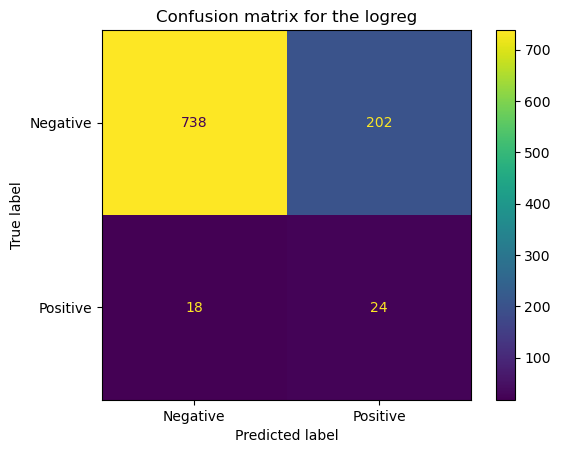

{'True Positive': 24, 'True Negative': 738, 'False Positive': 202, 'False Negative': 18}
KNN
The training accuracy for knn is: 0.9317
The test accuracy for knn is: 0.8004
Cross Val Score:  0.8717876855013639
The precision for knn is: 0.0722
The sensitivity for knn is: 0.3095
The F1 Score for knn is: 0.1171 





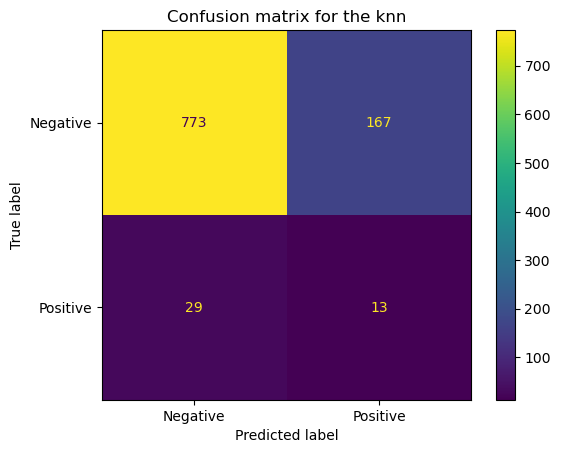

{'True Positive': 13, 'True Negative': 773, 'False Positive': 167, 'False Negative': 29}
CART
The training accuracy for cart is: 1.0
The test accuracy for cart is: 0.8625
Cross Val Score:  0.8731322795638885
The precision for cart is: 0.0571
The sensitivity for cart is: 0.1429
The F1 Score for cart is: 0.0816 





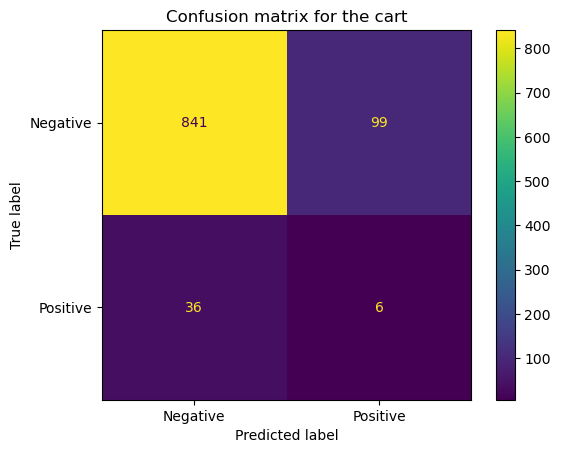

{'True Positive': 6, 'True Negative': 841, 'False Positive': 99, 'False Negative': 36}
BAGGED
The training accuracy for bagged is: 0.9968
The test accuracy for bagged is: 0.8819
Cross Val Score:  0.896011854906256
The precision for bagged is: 0.0795
The sensitivity for bagged is: 0.1667
The F1 Score for bagged is: 0.1077 





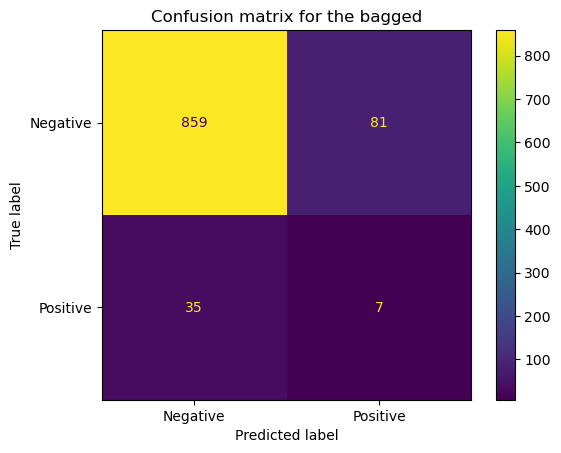

{'True Positive': 7, 'True Negative': 859, 'False Positive': 81, 'False Negative': 35}
RF
The training accuracy for rf is: 1.0
The test accuracy for rf is: 0.887
Cross Val Score:  0.9055163613455605
The precision for rf is: 0.0941
The sensitivity for rf is: 0.1905
The F1 Score for rf is: 0.126 





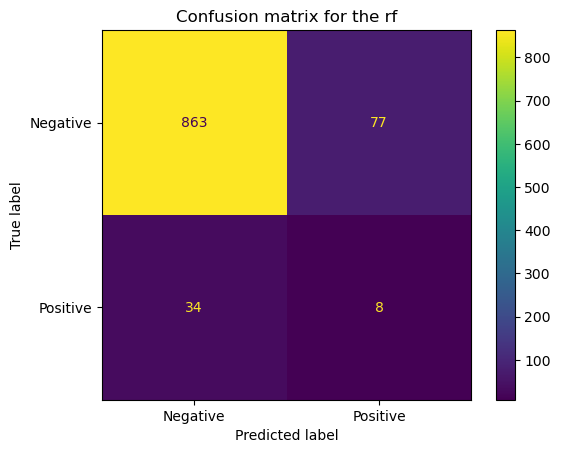

{'True Positive': 8, 'True Negative': 863, 'False Positive': 77, 'False Negative': 34}
ADA
The training accuracy for ada is: 0.8426
The test accuracy for ada is: 0.7709
Cross Val Score:  0.8274860583152576
The precision for ada is: 0.0897
The sensitivity for ada is: 0.4762
The F1 Score for ada is: 0.1509 





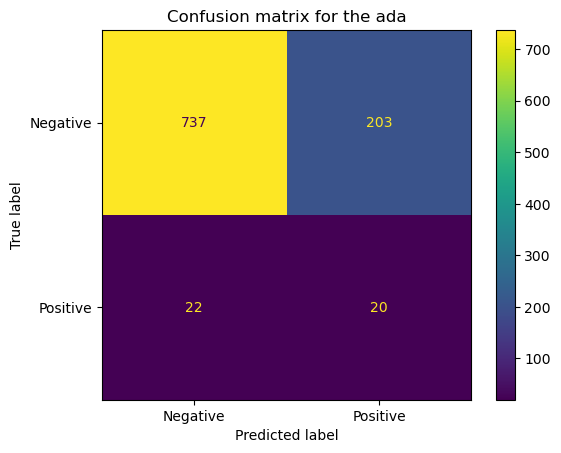

{'True Positive': 20, 'True Negative': 737, 'False Positive': 203, 'False Negative': 22}
SVC
The training accuracy for svc is: 0.8616
The test accuracy for svc is: 0.7984
Cross Val Score:  0.8361905733450736
The precision for svc is: 0.0806
The sensitivity for svc is: 0.3571
The F1 Score for svc is: 0.1316 





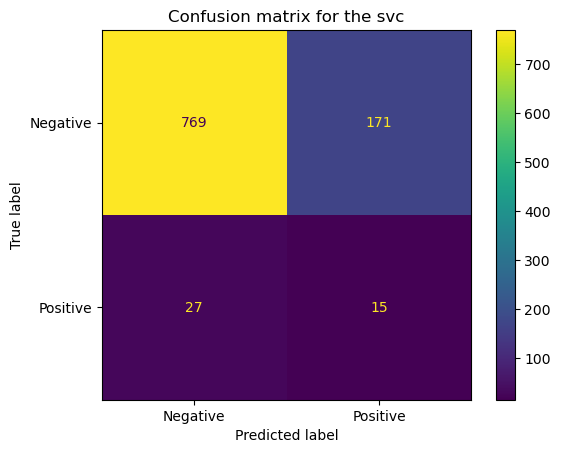

{'True Positive': 15, 'True Negative': 769, 'False Positive': 171, 'False Negative': 27}
XGB
The training accuracy for xgb is: 0.9941
The test accuracy for xgb is: 0.9002
Cross Val Score:  0.9282704794221448
The precision for xgb is: 0.1
The sensitivity for xgb is: 0.1667
The F1 Score for xgb is: 0.125 





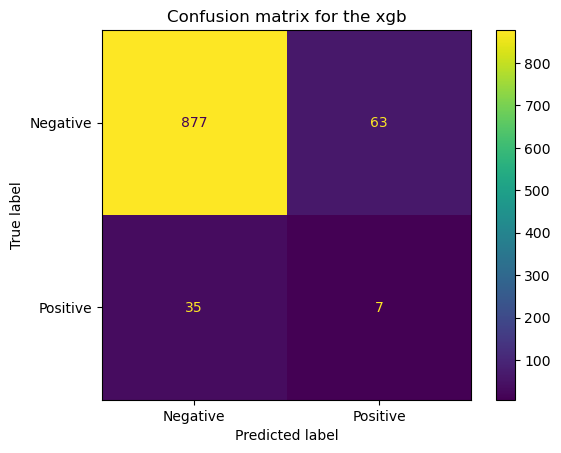

{'True Positive': 7, 'True Negative': 877, 'False Positive': 63, 'False Negative': 35}


In [163]:
for model in models:
    # Train Accuracy
    
    acc_train = accuracy_score(y_train_resh, model.predict(X_train_resh))
    
    # Test Accuracy
    acc_test = accuracy_score(y_test, model.predict(X_test))

    # Calculate Precision
    precision = precision_score(y_test, model.predict(X_test))
    
    # Calculate Sensitivity
    sensitivity = recall_score(y_test, model.predict(X_test))

    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) # F1 Score = 2 * (precision * recall) / (precision + recall)

    
    # Print results
    print(str(model.steps[1][0]).upper())
    print(f'The training accuracy for {str(model.steps[1][0])} is: {round(acc_train,4)}')
    print(f'The test accuracy for {str(model.steps[1][0])} is: {round(acc_test,4)}')
    print("Cross Val Score: ",cross_val_score(model, X_train_resh, y_train_resh, cv = 10).mean())
    print(f'The precision for {str(model.steps[1][0])} is: {round(precision,4)}')
    print(f'The sensitivity for {str(model.steps[1][0])} is: {round(sensitivity,4)}')
    print(f'The F1 Score for {str(model.steps[1][0])} is: {round(f1_score,4)} \n')
    print("======================================\n\n")

    # plot the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test,model.predict(X_test)).ravel() # confusion matrix and assign result
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test,model.predict(X_test)),display_labels=['Negative', 'Positive'])
    disp.plot(include_values=True)
    plt.title(f"Confusion matrix for the {str(model.steps[1][0])}")
    plt.show()
    print({'True Positive':tp, "True Negative": tn, "False Positive":fp, "False Negative": fn})


    

| Model               |  Processing Time |  Train Score | Test Score | Sensitivity | 
|:-------------------:|:----------------:|:------------:|:----------:|:-----------:|
| Logistic Regression |     21 ms        |    0.8120    |   0.7760   |   0.5714    |
| KNN                 |     26 ms        |    0.9317    |   0.8004   |   0.3095    |
| Decision Tree       |     44 ms        |    1.0000    |   0.8625   |   0.1429    |
| Bagging             |     199 ms       |    0.9968    |   0.8819   |   0.1667    |
| Random Forest       |     723 ms       |    1.0000    |   0.8890   |   0.2143    |
| AdaBoost            |     237 ms       |    0.8426    |   0.7709   |   0.4762    |
| SVM                 |     1.01 s       |    0.8616    |   0.7984   |   0.3571    |
| XGBoost             |     135 ms       |    0.9941    |   0.9002   |   0.1667    |

## 2.4 Hyperparameter Tuning

##### Based on the base models, we selected Logistic Regression and XGBoost for further tuning.

1) Logistic Regression: Selected based on the best sensitivity score.

2) XGBoost: The model with best potential due to the model nature. Both train and test score are good as well.

### 2.4.1 Logistic Regression

In [164]:
# set the pipeline
lr_pipeline = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])

pipe_params = {
'lr__penalty': ['l1','l2'],
'lr__solver':['liblinear'],
'lr__C': [0.1, 0.2,1],
}

# set the gridsearch
gs = GridSearchCV(lr_pipeline, # what object are we optimizing?
              param_grid=pipe_params, # what parameters values are we searching?
              n_jobs=-1,
              verbose = 1,
              scoring= "recall",
              cv=10) # 10-fold cross-validation.

In [165]:
%%time
# fit the gridsearch on train data
gs.fit(X_train_resh, y_train_resh)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


CPU times: user 212 ms, sys: 172 ms, total: 384 ms
Wall time: 3.27 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 0.2, 1], 'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['liblinear']},
             scoring='recall', verbose=1)

In [166]:
# AUC to compare models
lr_tuned_probabilities = gs.predict_proba(X_test)[:, 1]
auc_score_lr_tuned = roc_auc_score(y_test, lr_tuned_probabilities)
fpr_lr_tuned, tpr_lr_tuned, _ = roc_curve(y_test, lr_tuned_probabilities)

Best parameter: {'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Average Recall score with 5 folds: 0.8213923426948382
The training accuracy for 0.8107601713062098
The test accuracy for 0.7759674134419552
Recall score on train: 0.8373283059520603
Recall score on test: 0.5952380952380952
Sensitivity: 0.5952380952380952
Specificity: 0.7840425531914894
Precision: 0.10964912280701754


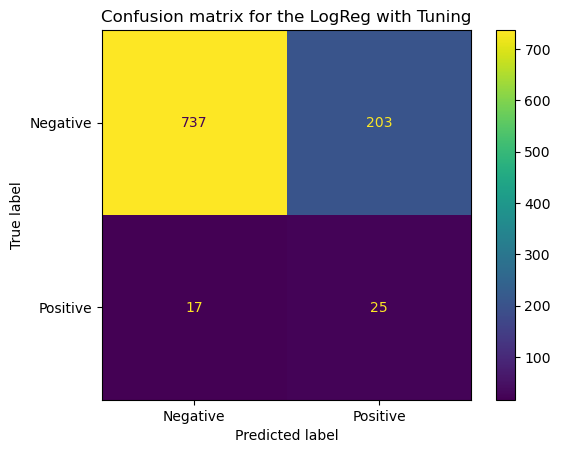

{'True Positive': 25, 'True Negative': 737, 'False Positive': 203, 'False Negative': 17}


{'lr__C': 0.1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

In [167]:
# set up the metrics
train_pred = gs.predict(X_train_resh)
y_pred = gs.predict(X_test) # get prediction
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel() # confusion matrix and assign result
precision = (tp / (tp+fp))
sensitivity = (tp / (tp+fn))

print(f"Best parameter: {gs.best_params_}")
print(f"Average Recall score with 5 folds: {gs.best_score_}")
print(f'The training accuracy for {accuracy_score(y_train_resh, train_pred)}')
print(f'The test accuracy for {accuracy_score(y_test, y_pred)}')
print(f"Recall score on train: {gs.score(X_train_resh, y_train_resh)}") 
print(f"Recall score on test: {gs.score(X_test, y_test)}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {tn / (tn+fp)}")
print(f"Precision: {precision}")

# plot the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel() # confusion matrix and assign result
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=['Negative', 'Positive'])
disp.plot(include_values=True)
plt.title(f"Confusion matrix for the LogReg with Tuning")
plt.show()
print({'True Positive':tp, "True Negative": tn, "False Positive":fp, "False Negative": fn})

gs.best_params_

### 2.4.2 XGBoost

In [168]:
estimator = XGBClassifier(
    objective= 'reg:logistic',
    nthread=4,
    seed=42
)

xgb_pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('xgb', estimator)
])

##### We run gridsearch in iteration process

In [169]:
# First gridsearch attemp
# parameters = {
#     'max_depth': range (2, 10, 1),
#     'n_estimators': range(10, 220, 40),
#     'learning_rate': [0.5,0.1, 0.01, 0.001]
# }

To save time and resources, we conduct grid searches in smaller chunks through an iterative process.  
Above code is the first attempt of grid search.  

In [170]:
parameters = {
    'max_depth': range (2),
    'n_estimators': range(10),
    'learning_rate': [0.01]
}

In [171]:
xgb_gs = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'recall',
    n_jobs = -1,
    cv = 10,
    verbose=True
)

In [172]:
%%time
# fit the gridsearch on train data
xgb_gs.fit(X_train_resh, y_train_resh)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


CPU times: user 269 ms, sys: 90.2 ms, total: 359 ms
Wall time: 3.13 s


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': range(0, 2),
                         'n_estimators': range(0, 10)},
             scoring='recall', verbose=True)

Best parameter: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 2}
Average Recall score with 5 folds: 0.9425970205489378
The training accuracy for 0.8107601713062098
The test accuracy for 0.5896130346232179
Recall score on train: 0.9555615405332615
Recall score on test: 0.8571428571428571
Sensitivity: 0.8571428571428571
Specificity: 0.5776595744680851
Precision: 0.08314087759815242
0.9425970205489378


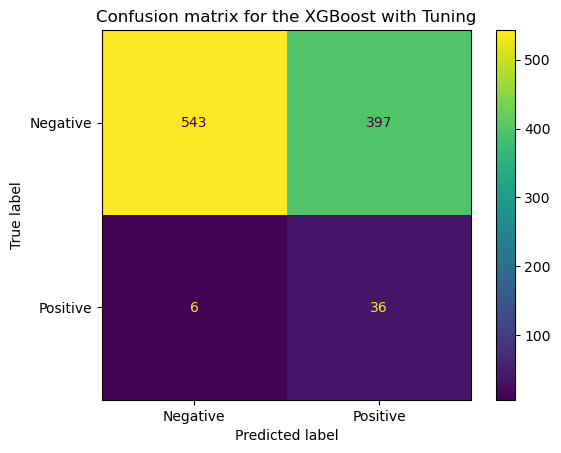

{'True Positive': 36, 'True Negative': 543, 'False Positive': 397, 'False Negative': 6}


In [173]:
# set up the metrics
y_pred = xgb_gs.predict(X_test) # get prediction
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel() # confusion matrix and assign result
precision = (tp / (tp+fp))
sensitivity = (tp / (tp+fn))

print(f"Best parameter: {xgb_gs.best_params_}")
print(f"Average Recall score with 5 folds: {xgb_gs.best_score_}")
print(f'The training accuracy for {accuracy_score(y_train_resh, train_pred)}')
print(f'The test accuracy for {accuracy_score(y_test, y_pred)}')
print(f"Recall score on train: {xgb_gs.score(X_train_resh, y_train_resh)}") 
print(f"Recall score on test: {xgb_gs.score(X_test, y_test)}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {tn / (tn+fp)}")
print(f"Precision: {precision}")


print(xgb_gs.best_score_)
xgb_gs.best_estimator_

# plot the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel() # confusion matrix and assign result
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred),display_labels=['Negative', 'Positive'])
disp.plot(include_values=True)
plt.title(f"Confusion matrix for the XGBoost with Tuning")
plt.show()
print({'True Positive':tp, "True Negative": tn, "False Positive":fp, "False Negative": fn})

| Model                     | Processing Time |  Train Score | Test Score | Sensitivity | 
|:-------------------------:|:---------------:|:------------:|:----------:|:-----------:|
| Logistic Regression       |     21 ms       |    0.8120    |   0.7760   |   0.5714    |
| Logistic Regression Tuned |     2.86 s      |    0.8107    |   0.7759   |   0.5952    |
| XGBoost                   |     135 ms      |    0.9941    |   0.9002   |   0.1667    |
| XGBoost Tuned             |     2.9 s       |    0.8107    |   0.5896   |   0.8571    |

##### Based on the tuned result, XGBoost is the best model based on the sensitivity score and selected as the final model.

# 3.0 Final Model

##### We train the final model based on the best parameters above

In [174]:
estimator = XGBClassifier(
    objective= 'reg:logistic',
    nthread=4,
    seed=42,
    learning_rate=0.01,
    max_depth=2,
    n_estimators=10
    
)

xgb_pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('xgb', estimator)
])

# fit the final model
xgb_pipeline.fit(X_train_resh, y_train_resh)

# set the y prediction for model evaluation purpose
final_y_pred = xgb_pipeline.predict(X_test)


## 3.1 ROC AUC

##### Creating ROC AUC plot to evaluate the performance of the final model - XGBoost

In [175]:
# AUC to compare models
xgb_tuned_probabilities = xgb_pipeline.predict_proba(X_test)[:, 1]
auc_score_xgb_tuned = roc_auc_score(y_test, xgb_tuned_probabilities)
fpr_xgb_tuned, tpr_xgb_tuned, _ = roc_curve(y_test, xgb_tuned_probabilities)

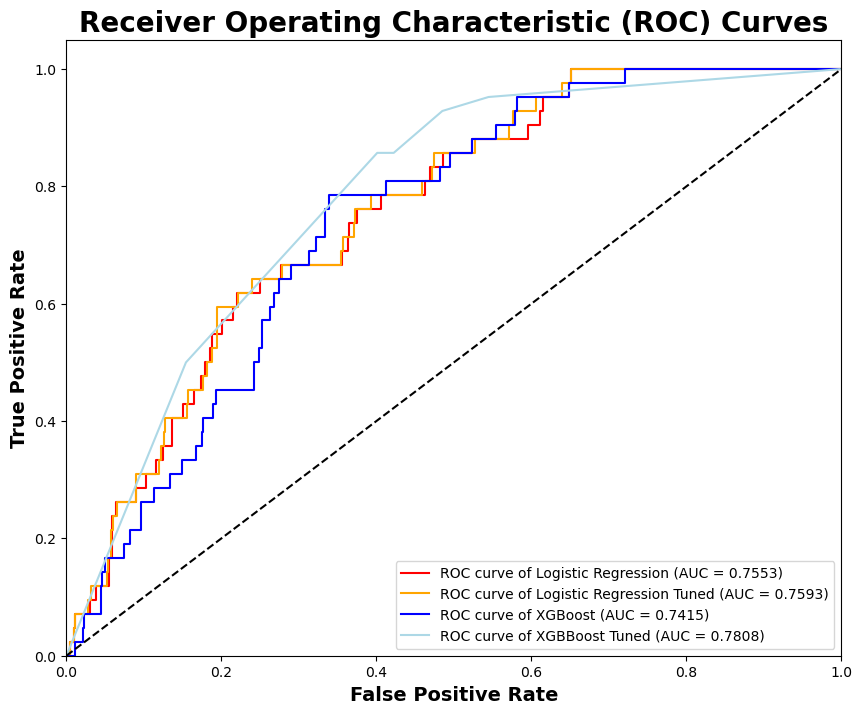

In [176]:
# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr_lr, tpr_lr, color = 'red', label=f'ROC curve of Logistic Regression (AUC = {auc_score_lr:0.4f})')
plt.plot(fpr_lr_tuned, tpr_lr_tuned, color='orange', label=f'ROC curve of Logistic Regression Tuned (AUC = {auc_score_lr_tuned:0.4f})')
plt.plot(fpr_xgb, tpr_xgb, color='blue', label=f'ROC curve of XGBoost (AUC = {auc_score_xgb:0.4f})')
plt.plot(fpr_xgb_tuned, tpr_xgb_tuned, color='lightblue', label=f'ROC curve of XGBBoost Tuned (AUC = {auc_score_xgb_tuned:0.4f})')

# Plotting the diagonal line for no skill classifier
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, weight='bold')
plt.ylabel('True Positive Rate', fontsize=14, weight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=20, weight="bold")
plt.legend(loc="lower right")

# 4.0 Export Model PKL

##### Export model for streamlit.

In [177]:
import pickle

filename = '../models/model_stroke.pkl'

with open(filename, 'wb') as file:
    pickle.dump(xgb_pipeline, file)

# 5.0 Summary - Stroke Detector Model

##### XGBoost is selected for the stroke detector model.

##### In the next notebook 3.0, we will build the model for CT brain images model.